# Policy Gradients: REINFORCE Baseline with LunarLander

In [1]:
# Install dependencies
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet==1.5.27 --quiet

In [2]:
import io
import os
import glob

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import gym
from gym import spaces
from gym.wrappers import Monitor

In [3]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### LunarLander

LunarLander is an OpenAI gym environment (env). In this env the agent tries to land a space craft safely on the ground by firing the main, left, or right engine. The agent receives a reward for navigating to the landing pad and turning off the engine, a large reward for a safe landing, a large negative reward for an unsafe landing, and a small negative reward for using the engines. There are discrete and continuous versions of LunarLander.

In [4]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""
import base64

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [16]:
env = gym.make('LunarLander-v2')
env.reset()

#prev_screen = env.render(mode='rgb_array')
#plt.imshow(prev_screen)

env = wrap_env(env)
env.reset()

for i in range(200):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()
show_video()

### Policy Gradient Methods

In policy gradient methods, we update the policy directly. Ie we parameterize the policy and perform gradient descent updates on the policy parameters seeking to improve the policy. This is in contrast to section 3 where we learned estimates of the state or action-values. Then we extracted a policy based on those values, like with the epsilon greedy DQN policy.

### Discrete vs. Continuous Action Spaces

PG methods can work in discrete and continuous action spaces. The DQN method we went over in section three required discrete action spaces: ie a limited number of actions. In continuous actions spaces there are an infinite number of actions as the action can be any value in a range. Continuous action spaces are often parameterized by a probability distribution and we learn the parameters of the distribution. For example we assume the actions come from a Gaussian distribution and try to learn the mean and standard deviation of the Gaussian that leads to the best policy. 

### REINFORCE with Lunar Lander

In this example, we will solve the discrete version of Lunar Lander using the REINFORCE with baseline method.

In [6]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim=-1) #-1 to take softmax of last dimension
    
class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [7]:
class PGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, vf_lr, discount ):
        self.action_size = action_size
        self.actor_net = ActorNet(state_size, action_size, hidden_size).to(device)
        self.vf_net = ValueFunctionNet(state_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=actor_lr)
        self.vf_optimizer = optim.Adam(self.vf_net.parameters(), lr=vf_lr)
        self.discount = discount
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action_probs = self.actor_net(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action_probs = action_probs.detach().cpu().numpy()
            action = np.random.choice(np.arange(self.action_size), p=action_probs)
        return action

    def train(self, state_list, action_list, reward_list):
        
        #turn rewards into return
        trajectory_len = len(reward_list)
        return_array = np.zeros((trajectory_len,))
        g_return = 0.
        for i in range(trajectory_len-1,-1,-1):
            g_return = reward_list[i] + self.discount*g_return
            return_array[i] = g_return
            
        # create tensors
        state_t = torch.FloatTensor(state_list).to(device)
        action_t = torch.LongTensor(action_list).to(device).view(-1,1)
        return_t = torch.FloatTensor(return_array).to(device).view(-1,1)
        
        # get value function estimates
        vf_t = self.vf_net(state_t).to(device)
        with torch.no_grad():
            advantage_t = return_t - vf_t
        
        # calculate actor loss
        selected_action_prob = self.actor_net(state_t).gather(1, action_t)
        # REINFORCE loss:
        #actor_loss = torch.mean(-torch.log(selected_action_prob) * return_t)
        # REINFORCE Baseline loss:
        actor_loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 

        # calculate vf loss
        loss_fn = nn.MSELoss()
        vf_loss = loss_fn(vf_t, return_t)
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), vf_loss.detach().cpu().numpy()
    

In [17]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
env.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# hyperparameters
episodes = 3000 # run agent for this many episodes
hidden_size = 64 # number of units in NN hidden layers
actor_lr = 0.001 # learning rate for actor
value_function_lr = 0.001 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = PGAgent(state_size, action_size, hidden_size, actor_lr, value_function_lr, discount)

In [18]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

env.reset()
env = wrap_env(env)
state = env.reset()

for ep in range(episodes):
    state_list, action_list, reward_list = [], [], []
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        env.render()
        
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        state = next_state

        # end episode early
        if total_reward < -250:
            done = 1 
            env.stats_recorder.done = True
        
        if done:
            state = env.reset()
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every), 
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.
            break

        


Episode: 0 Timestep: 75 Total reward: -161.4 Episode length: 75.0 Actor Loss: -0.1435 VF Loss: 0.1117
Episode: 10 Timestep: 952 Total reward: -132.2 Episode length: 87.7 Actor Loss: -1.0209 VF Loss: 0.7218
Episode: 20 Timestep: 2005 Total reward: -206.0 Episode length: 105.3 Actor Loss: -1.1588 VF Loss: 0.9957
Episode: 30 Timestep: 2907 Total reward: -168.8 Episode length: 90.2 Actor Loss: -0.6067 VF Loss: 0.3409
Episode: 40 Timestep: 3828 Total reward: -228.9 Episode length: 92.1 Actor Loss: -0.6085 VF Loss: 0.4371
Episode: 50 Timestep: 4783 Total reward: -122.7 Episode length: 95.5 Actor Loss: 0.3344 VF Loss: 0.2092
Episode: 60 Timestep: 5950 Total reward: -161.2 Episode length: 116.7 Actor Loss: 0.2940 VF Loss: 0.1935
Episode: 70 Timestep: 6989 Total reward: -175.7 Episode length: 103.9 Actor Loss: -0.0054 VF Loss: 0.1858
Episode: 80 Timestep: 7860 Total reward: -208.2 Episode length: 87.1 Actor Loss: -0.4139 VF Loss: 0.2700
Episode: 90 Timestep: 8869 Total reward: -151.7 Episode le

In [19]:
show_video()

Text(0, 0.5, 'Episode Reward')

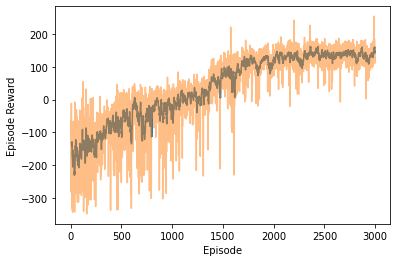

In [20]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

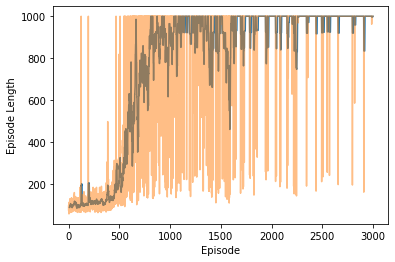

In [21]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

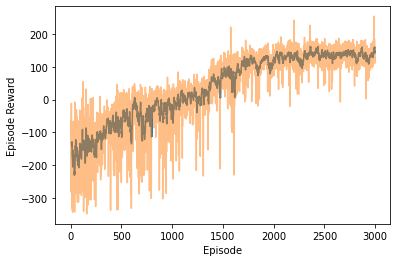

In [22]:
from google.colab import files
# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

plt.savefig(fname="PG.png")
files.download("PG.png")